In [ ]:
import numpy as np
import sympy
import pandas as pd
import argparse
from scipy import stats

# from dvm_funcs import dvm_solver

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline 





## Discrete Vortex Solver functions


In [ ]:

def airfoil_discretization(args):
    
    naca = str(args["naca"]) 
    alpha = args["alpha"]
    geo = args["geometry"]
    npanels = args["panels"]
    flap_pos = args["flappos"]
    flap_alpha = args["flapalpha"]
    
    max_camber = int(naca[0])/100 
    max_camber_pos = int(naca[1])/10
    thick = int(naca[2:])
    npoints = npanels + 1
    alpha = np.deg2rad(alpha)
        
    if geo == "uniform":
        X = np.linspace(0,1, num=npoints, endpoint=True)
    elif geo == "fullcosine":
        _a = np.arange(1,npoints+1) # arange func stops at n-1
        X = 0.5 * (1 - np.cos(((_a-1) / npanels) * np.pi))
        
    if flap_pos != False:
        flap_alpha = np.deg2rad(flap_alpha)
            
    Z = np.zeros(npoints)    
    for i in range(npoints):
        if X[i] <= max_camber_pos:
            Z[i] = (max_camber/(max_camber_pos**2)) * (2 * max_camber_pos*(X[i])- (X[i]**2))
            
        elif X[i] > max_camber_pos:
             Z[i] = (max_camber/(1-max_camber_pos)**2)*(1-2*max_camber_pos+2*max_camber_pos*(X[i])-(X[i]**2)) 
                
        # Flap
        if X[i] >= flap_pos:
            Z[i] = Z[i] - np.tan(flap_alpha) * (X[i] - flap_pos)
    
    XZ_space = np.vstack([X, Z])    
    return XZ_space  

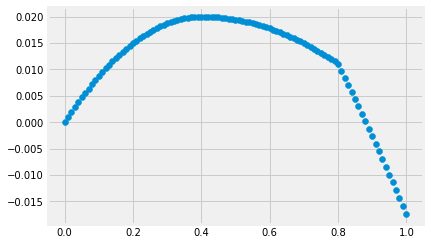

In [ ]:
args = {"naca": "2408", 
        "alpha": 4  ,
        "geometry": "uniform",
        "panels": 100,
        "flappos": 0.8,
        "flapalpha":5
        }
x,z = airfoil_discretization(args)
plt.scatter(x,z)

In [ ]:
def dvm_solver2(args):
    alpha = args["alpha"]
    npanels = args["panels"]
    npoints = npanels + 1
    alpha = np.deg2rad(alpha)
    
    XZ_space = airfoil_discretization(args)
        
    vortex_points = np.zeros((2,npanels))
    ctrl_points = np.zeros((2,npanels))  
    for i in range(npanels): 
        # panel length
        cordlen = np.sqrt( (XZ_space[0][i+1] - XZ_space[0][i])**2 +
                           (XZ_space[1][i+1] - XZ_space[1][i])**2 )
        
        angle = np.arctan( (XZ_space[1][i+1] - XZ_space[1][i]) / 
                            (XZ_space[0][i+1] - XZ_space[0][i])   )
        
        vortex_points[0][i] = XZ_space[0][i] + 1/4 * cordlen * np.cos(angle)
        vortex_points[1][i] = XZ_space[1][i] + 1/4 * cordlen * np.sin(angle)
        
        ctrl_points[0][i] = XZ_space[0][i] + 3/4 * cordlen * np.cos(angle)
        ctrl_points[1][i] = XZ_space[1][i] + 3/4 * cordlen * np.sin(angle)
        
        
    inf_coeff = np.zeros((npanels,npanels))    
    RHS = np.zeros((npanels,1))
    for i in range(npanels): #add npanels -1 ??? last i+1 gonna crash
        XZ_deltas = np.zeros((2,1))
        #XZ_deltas = XZ_space[:,i+1] - XZ_space[:,i]
        XZ_deltas[0] = XZ_space[0][i+1] - XZ_space[0][i]
        XZ_deltas[1] = XZ_space[1][i+1] - XZ_space[1][i]
        
        tan_vector = np.zeros((2,1))
        #tan_vector = XZ_deltas / np.sqrt(XZ_deltas[]**2)
        tan_vector[0] = XZ_deltas[0] / np.sqrt( XZ_deltas[0]**2 + XZ_deltas[1]**2 )
        tan_vector[1] = XZ_deltas[1] / np.sqrt( XZ_deltas[0]**2 + XZ_deltas[1]**2 )
        
        norm_vector = np.zeros((2,1))
        norm_vector[0] = - tan_vector[1]
        norm_vector[1] = tan_vector[0]
        
        for j in range(npanels):
            XZ_deltas[0] = ctrl_points[0][i] - vortex_points[0][j]
            XZ_deltas[1] = ctrl_points[1][i] -vortex_points[1][j]
            
            r = np.sqrt(XZ_deltas[0]**2 + XZ_deltas[1]**2 )
            
            induced_vel = np.zeros((2,1))
            induced_vel[0] = 1/(2*np.pi)* XZ_deltas[1]/(r)**2
            induced_vel[1] = -1/(2*np.pi)* XZ_deltas[0]/(r)**2
            
            inf_coeff[i][j] = induced_vel[0] * norm_vector[0] + induced_vel[1]*norm_vector[1]
            
        RHS[i] = -( np.cos(alpha)*norm_vector[0] + np.sin(alpha)* norm_vector[1] )
        
    gamma = np.linalg.solve( inf_coeff, RHS)
    # flat plate test
    #gamba = gamma/np.sin(alpha)*5/np.pi

    cl = 2*np.sum(gamma)
    
    # _sm = np.zeros((npanels, 1))
    # for i in range(npanels):
    #     _sm[i] = gamma[i]*vortex_points[0][i]*np.cos(alpha)
    
    
    # cmle = -2*np.sum(_sm)
    cm_le = -2* ( gamma.reshape(1,-1) * vortex_points[0,:] * np.cos(alpha)).sum()
    cm_ac = cm_le + cl/4
    # plt.plot(XZ_space)

    return {"cl": cl, "cm_le": cm_le,"cm_ac": cm_ac}

## Fast Analytical solution using symbolic math library sympy

In [ ]:
import sympy
def analytical_TAT_solver(alpha_0=4, f_0=0.02, p_0=0.4):
  alpha, f, p, x, theta = sympy.symbols("alpha f p x theta")
  alpha, f, p = alpha_0*np.pi/180, f_0, p_0


  z_0_p = (f/(p**2)) * (2*p*x -x**2)
  z_p_1 = (f/(1-p)**2) * (1 - 2*p +2*p*x - x**2)
  dz_0_p = sympy.diff(z_0_p, x).subs(x, 0.5*(1-sympy.cos(theta)))
  dz_p_1 = sympy.diff(z_p_1, x).subs(x, 0.5*(1-sympy.cos(theta)))
  theta_p = np.arccos(-(p*2 -1))


  cl = (2*np.pi)*(alpha+(1/np.pi)*(sympy.integrate(dz_0_p*(sympy.cos(theta)-1), 
                                          (theta,0,theta_p))
                                  + sympy.integrate(dz_p_1*(sympy.cos(theta)-1), 
                                            (theta,theta_p,np.pi))))

  A_1 = (2/np.pi)* ( sympy.integrate(dz_0_p*sympy.cos(theta), 
                                    (theta, 0, theta_p)) 
                    + sympy.integrate(dz_p_1*sympy.cos(theta), 
                                      (theta, theta_p, np.pi)))

  A_2 = (2/np.pi)* ( sympy.integrate(dz_0_p*sympy.cos(2*theta), 
                                    (theta, 0, theta_p)) 
                    + sympy.integrate(dz_p_1*sympy.cos(2*theta), 
                                      (theta, theta_p, np.pi)))
  cm_le = -(cl/4 + np.pi/4*(A_1-A_2))
  cm_ac = np.pi/4 *(A_2-A_1)

  return {"cl": cl.evalf(), "cm_le": cm_le.evalf(), "cm_ac": cm_ac.evalf(), "A_1": A_1.evalf(), "A_2": A_2.evalf() }

In [ ]:
results = analytical_TAT_solver(alpha_0=4, f_0=0.02, p_0=0.4)
print("ANALYTICAL RESULTS:")
for key, value in results.items():
  print(key, value)


ANALYTICAL RESULTS:
cl 0.666443984963538
cm_le -0.219730509700976
cm_ac -0.0531195134600912
A_1 0.0814951416008563
A_2 0.0138612764663765


In [ ]:
def validate_dvm(args):

  output = dvm_solver2(args)
  print("cl = {}, \n cmle = {} \n cm0 = {}".format(*(output).values()))

In [ ]:
%%time
args = {"naca": "2408", 
            "alpha": 4 ,
            "geometry": "fullcosine",
            "panels": 50,
            "flappos": False,
            "flapalpha":False
            }
validate_dvm(args)

cl = 0.6612588663264093, 
 cmle = -0.2182181518231073 
 cm0 = -0.05290343524150498
CPU times: user 63.3 ms, sys: 8.24 ms, total: 71.6 ms
Wall time: 64.6 ms


# 1 - Verification Assessment


 - Get data for different panel numbers using ouur dvm solver.
 - Prepare dataframe with solver data and error data
 - Clean dataframe
 - Plot $C_l$ vs $C_{l}$-err and $C_M$ vs $C_l$-err 




In [ ]:
# initialization needed to "append" numpyarrays later, inside loop 
data_array = np.array([[0,0]]) 
npanels = np.linspace(5,200,100, dtype=int) # linspace of number of panels
panel_index=[0]
for panel in npanels:
    args = {"naca": "2408", 
        "alpha": 4  ,
        "geometry": "uniform",
        "panels": panel,
        "flappos": False,
        "flapalpha":False
        }
    panel_index.append(panel) 
    _result = dvm_solver2(args)
    _cl_cmle = [_result["cl"], _result["cm_le"] ]
    data_array = np.vstack((data_array, _cl_cmle))
    
    
data = pd.DataFrame(data_array, index=panel_index, columns = ["cl", "cm_le"])
data.index.name = "Panels"
# Deleting first row created by numpyarray initialization 
data = data.drop([0])




#### TAT theoretical reference values and  preview max number of panels data

Using Thin-Airfoil Theory we calculate the theoretical reference values to compare our model to. 


$C_l$ = 0.666443984963538,

$Cm_{le}$" =  -0.219730509700976 


In [ ]:
# TAT theoretical reference values
ref_values = {"cl":0.666443984963538,"cm_le": -0.219730509700976 }

# Adding error columns for Cl and Cm
data["cl_error"] = abs(1- data["cl"]/ref_values["cl"])
data["cm_error"] = abs(1- data["cm_le"]/ref_values["cm_le"])
data


,cl,cm_le,cl_error,cm_error
Panels,,,,
5,0.624748,-0.209214,0.062565,0.047861
6,0.631626,-0.211105,0.052245,0.039255
8,0.640170,-0.213299,0.039424,0.029270
10,0.645257,-0.214511,0.031792,0.023754
12,0.648643,-0.215281,0.026710,0.020250
...,...,...,...,...
192,0.664446,-0.218494,0.002997,0.005629
194,0.664457,-0.218496,0.002981,0.005620
196,0.664468,-0.218498,0.002965,0.005611


In [ ]:

data.to_csv("grid_convergence_200plus.csv")

### Convergence Plots

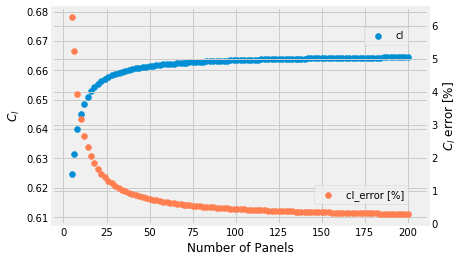

In [ ]:
fig, ax1 = plt.subplots(1,1)
# data["cl"].plot(ax=ax1, label="cl")
ax1.scatter(data.index.values, data["cl"], label="cl")
ax2 = ax1.twinx()
# (data["cl_error"]*100).iloc[:4].plot(ax=ax2, color="coral", label="cl_error [%]")
ax2.scatter(data.index.values,(data["cl_error"]*100), color="coral", label="cl_error [%]")
ax1.set_ylabel("$C_l$")
ax2.set_ylabel("$C_l$ error [%]")
ax1.legend(loc=1, borderaxespad=2)
ax2.legend(loc=4, borderaxespad=2)
ax2.set_xlabel("Number of Panels")
ax1.set_xlabel("Number of Panels")

plt.show()

In [ ]:
fig.savefig("cl_err2.png", bbox_inches='tight' )

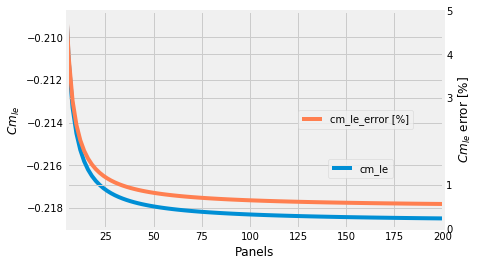

In [ ]:
fig2, ax12 = plt.subplots(1,1)
data["cm_le"].plot(ax=ax12, label="cm_le")
ax22 = ax12.twinx()
(data["cm_error"]*100).plot(ax=ax22,color="coral", label="cm_le_error [%]")
ax12.set_ylabel("$Cm_{le}$")
ax22.set_ylabel("$Cm_{le}$ error [%]")
ax22.set_yticks([0, 1, 3, 4, 5])
ax12.legend(loc=4, borderaxespad=5)
ax22.legend(loc=5, borderaxespad=3)
ax2.set_xlabel("Number of Panels")
ax1.set_xlabel("Number of Panels")

plt.show()

In [ ]:
fig2.savefig("cmle_error2.png", bbox_inches='tight')

# Flap efficency
Using 170 panels, and varying the flap-chord ratio

In [ ]:
# Prepare data verification array
dataverif_array = np.array([[0,0]]) 
flap_chord_ratios = np.array([0.15, 0.20, 0.25, 0.30])
# Hinge positions in percent of chord
flap_positions = 1 - flap_chord_ratios
flap_positions = np.around(flap_positions, decimals=3)
flap_angles = np.linspace(0,10,20) 
alphaL0_dic = {}

for position in flap_positions:
    for flap in flap_angles:
        args = {"naca": "2408", 
            "alpha": 0  ,
            "geometry": "fullcosine",
            "panels": 105,
            "flappos": position,
            "flapalpha":flap
            }
        _cl = dvm_solver2(args)["cl"]
        _alphaL0 = np.rad2deg(-(_cl/(2*np.pi)))
        if flap == 0:
            alphaL0_dic[position] = []
        alphaL0_dic[position].append(_alphaL0)

        
alphaL0_df = pd.DataFrame(alphaL0_dic, index = flap_angles, columns = flap_positions)


alphaL0_df.head(7)

,0.85,0.80,0.75,0.70
0.000000,-2.057893,-2.057893,-2.057893,-2.057893
0.526316,-2.308088,-2.344712,-2.375976,-2.403310
1.052632,-2.558162,-2.631399,-2.693917,-2.748579
1.578947,-2.808139,-2.917979,-3.011746,-3.093734
2.105263,-3.058043,-3.204479,-3.329492,-3.438805
2.631579,-3.307897,-3.490926,-3.647185,-3.783825
3.157895,-3.557725,-3.777346,-3.964853,-4.128826


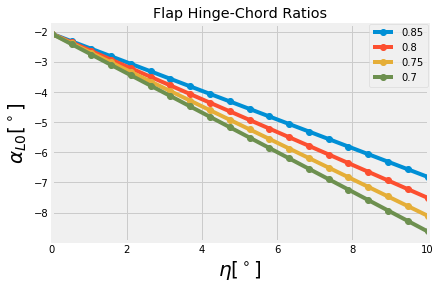

In [ ]:
fig3, ax13 = plt.subplots(1,1)
alphaL0_df.plot(ax=ax13, marker="o")
ax13.set_ylabel("$\\alpha_{L0}[^\circ]$", fontsize=20)
ax13.set_xlabel("$\\eta[^\circ]$", fontsize=20)
ax13.set_title("Flap Hinge-Chord Ratios")
ax13.legend( loc=0, borderaxespad=0)

plt.show()

In [ ]:
fig3.savefig("chord-flap.png")

##### Find Slope/ Flap efficency

We find the slope for every flap-chord ratio

In [ ]:
slopes = {}
for pos in alphaL0_df.columns:
    slope, _a = np.polyfit(x=alphaL0_df.index, y=alphaL0_df[pos], deg=1)
    slopes[pos] = slope 
flap_df = pd.DataFrame(slopes,columns = alphaL0_df.columns ,index=["Flap Efficency Factor"])


In [ ]:
flap_dfT = flap_df.T
flap_dfT["E"] = 1- flap_dfT.index
flap_dfT["Eff"] = abs(flap_dfT["Flap Efficency Factor"])
flap_dfT.head()

,Flap Efficency Factor,E,Eff
0.85,-0.475383,0.15,0.475383
0.80,-0.545022,0.20,0.545022
0.75,-0.604519,0.25,0.604519
0.70,-0.656589,0.30,0.656589


Now we modify and transpose our dataframe to plot The flap efficency factor vs the Flap-Chord Ratio **E**.

$E = 1- \frac{x_h}{c} $

Where $\frac{x_h}{c}$ is the hinge position in percent of chord.


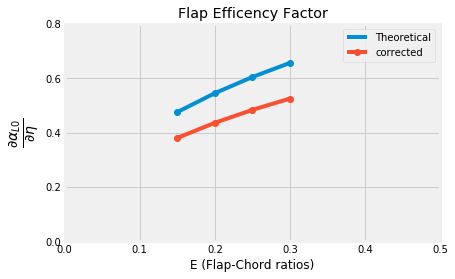

In [ ]:
flap_dfT["corrected"] = flap_dfT["Eff"] * 0.8
fig32, ax132 = plt.subplots(1,1)
flap_dfT.plot(ax = ax132, x ="E", y= "Eff", marker = "o", label= "Theoretical",)
flap_dfT.plot(ax = ax132, x ="E", y= "corrected", marker = "o", label="corrected" )

ax132.set_ylabel("$\\frac{\\partial \\alpha_{L0}}{\\partial \\eta}$", fontsize=20);
ax132.set_xlabel("E (Flap-Chord ratios)");
ax132.set_title("Flap Efficency Factor");
ax132.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]);
ax132.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8]);

In [ ]:
fig32.savefig("flap_E3.png", bbox_inches='tight')

We obtain the expected plot shape, such as the one in pp. 190 in  Abbot and Doenhoff Theory of Wing Sections. Values for E from 0.15 to 0.30 correspond very accurately to the theoretical curve plot from Abbot and Doenhoff.


# 2- Validation assessment

- $C_{L,\alpha}$
- $\alpha_{l0}$
- $C_{M0}$
- Flap efficency

In [ ]:
# Prepare data validation array with varying angles of attacks
datavalid_array = np.array([[0,0]]) 
alphas = np.linspace(-5,10,25, dtype=float) 

for alpha in alphas:
    args = {"naca": "2408", 
            "alpha": alpha  ,
            "geometry": "fullcosine",
            "panels": 105,
            "flappos": False,
            "flapalpha":False
            }
    _result = dvm_solver2(args)
    datavalid_array = np.vstack((datavalid_array,[_result["cl"], _result["cm_le"]]))

# Delete initialization row
datavalid_array = np.delete(datavalid_array, (0), axis=0)

datavalid_df = pd.DataFrame(datavalid_array, index = alphas, columns = ["cl", "cm_le"])
datavalid_df.index.name = "alpha"
datavalid_df.head()

,cl,cm_le
alpha,,
-5.000,-0.322892,0.027318
-4.375,-0.254370,0.010230
-3.750,-0.185818,-0.006888
-3.125,-0.117244,-0.024029
-2.500,-0.048656,-0.041184


#### Plot Cl CM vs alpha

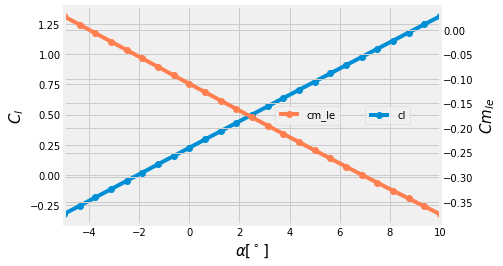

In [ ]:
fig4, ax14 = plt.subplots(1,1)
datavalid_df["cl"].plot(ax=ax14, label="cl", marker="o")
ax24 = ax14.twinx()
datavalid_df["cm_le"].plot(ax=ax24,color="coral", label="cm_le", marker = "o")
ax14.set_ylabel("$C_l$",fontsize=15)
ax24.set_ylabel("$Cm_{le}$",fontsize=15)
ax14.set_xlabel("$\\alpha [^\\circ]$", fontsize=15)
ax24.set_xlabel("$\\alpha [^\\circ]$",fontsize=15)

ax14.legend(loc=7, borderaxespad=3)
ax24.legend(loc=5, borderaxespad=10)

plt.show()


# save fig
# plt.savefig("CLCM-alpha.png")
fig4.savefig("cl-cm-alpha_final2.png", bbox_inches='tight')

In [ ]:
# Finding cl_a, a_lo_cm0
cl_a, _ = np.polyfit(alphas*np.pi/180, datavalid_df["cl"], 1)
_, a_l0 = np.polyfit(datavalid_df["cl"], alphas*np.pi/180 , 1)

cm_a, _ = np.polyfit(alphas*np.pi/180, datavalid_df["cm_le"],  1)
_, cm_0 = np.polyfit(datavalid_df["cm_le"],alphas*np.pi/180,  1)

print("cl_a = {} \na_l0={}={}deg\ncm_o={} \n ratio = {}".format(cl_a, a_l0, a_l0*180/np.pi, cm_0, -cm_a/cl_a))

cl_a = 6.256801228376121 
a_l0=-0.03596403845754531=-2.060587617863529deg
cm_o=-0.0707497423865473 
 ratio = 0.24653471206147592


In [ ]:
EXPERIMENTAL_a_l0 = -2.109
EXPERIMENTAL_cl_a = 2*np.pi
EXPERIMENTAL_cm_0 = -0.0504

valid_comparison = pd.DataFrame({"cl_a": [cl_a, EXPERIMENTAL_cl_a], "a_l0": [a_l0*180/np.pi, EXPERIMENTAL_a_l0], "cm_0":[cm_0, EXPERIMENTAL_cm_0]}, index=["Calculated", "Experimental"])
valid_comparison.loc["Error"] = [abs(1-cl_a/EXPERIMENTAL_cl_a), abs(1-abs((a_l0*180/np.pi)/EXPERIMENTAL_a_l0)),  abs(1-abs(cm_0/EXPERIMENTAL_cm_0))]
valid_comparison.head()

,cl_a,a_l0,cm_0
Calculated,6.256801,-2.060588,-0.070750
Experimental,6.283185,-2.109000,-0.050400
Error,0.004199,0.022955,0.403765


 - As expected, the $C_{L,\alpha}$ obtained is approximately $2\pi$ 
 - Also the $\frac{C_{m, \alpha}}{C_{L,\alpha}}$ ratio equals 0.2467, a value very close to 1/4 of the chord, which is the aerodynamic center.
 
 - Comparing with the experimental results we get errors of less than 1% and a greater error with the Cm0.

# 3 -  Discussion

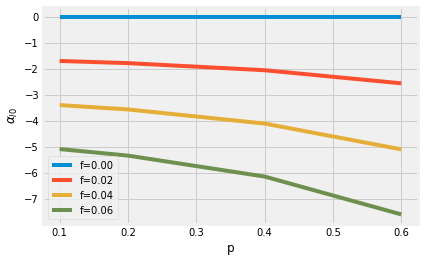

In [ ]:
# discussion_array = np.array([[0,0,0]]) 
nacaf = [0,2,4,6]
nacap = np.array([1,2,4,6])
datafs = []
dataps = {"a_l0": [], "cm_0": []}
for f in nacaf:
    for p in nacap:
      naca = "{}{}08".format(str(f), str(p))
      args = {"naca": naca, 
              "alpha": 0  ,
              "geometry": "fullcosine",
              "panels": 105,
              "flappos": False,
              "flapalpha":False
              }
      result = dvm_solver2(args)
      _cl, _cm_0 = result["cl"], result["cm_ac"]
      _a_l0 = np.rad2deg(-(_cl/(2*np.pi)))
      dataps["a_l0"].append(_a_l0)
      dataps["cm_0"].append(_cm_0)
    # data_discuss.append(f_curve)
    datafs.append(dataps)
    dataps = {"a_l0": [], "cm_0": []}

for idx, f_curve in enumerate(datafs):
  # names = ["{}{}08".format(str(f), str(p)) for p in nacap for f in nacaf] 
  plt.plot(nacap*0.1, f_curve["a_l0"],)
plt.xlabel("p")
plt.ylabel("$\\alpha_{l0}$")
plt.legend(["f={:.2f}".format(f*0.01) for f in nacaf])
plt.savefig("discussion_cl.png", bbox_inches='tight')


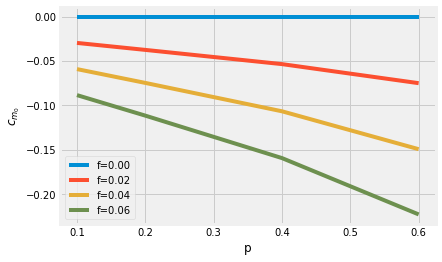

In [ ]:
for idx, f_curve in enumerate(datafs):
  # names = ["{}{}08".format(str(f), str(p)) for p in nacap for f in nacaf] 
  plt.plot(nacap*0.1, f_curve["cm_0"],)
plt.xlabel("p")
plt.ylabel("$c_{m_{0}}$")
plt.legend(["f={:.2f}".format(f*0.01) for f in nacaf])
plt.savefig("discussion_cm.png", bbox_inches='tight')

alpha lzero decreases with an increasing max camber(f) and max chamber position.( p) For high fs, al0 and cm0 decrease more notably along p.

